In [36]:
import numpy as np
from PIL import Image
import os
from model import *
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw

In [103]:
text_prompt = 'Magic madness heaven sin Saw you there and I thought'  # lets keep a text prompt in our repo lamao
# number of words = number of words in text_prompt
num_words = len(text_prompt.split())
print(num_words)

output_folder_path = '../../DataSet/internet/'
page_width = 300  # can be changed
img_height = 60 

10


In [31]:
# resize image to a fixed height
def resize_image(image, required_height):
    image_size = np.array(image).shape
    height, width = image_size[0], image_size[1]
    scale_factor = required_height / height
    width = int(width * scale_factor)
    resized_image = image.resize((width, required_height))
    return resized_image

In [51]:
def create_list(output_folder_path):
    width_list = []
    image_list = []
    for files in os.listdir(output_folder_path):
        if files.endswith(".png"):
            image_path = output_folder_path + files
            image = Image.open(image_path)
            image = image.convert('L')
            image_size = np.array(image).shape
            if image_size[0]!=img_height:
                image = resize_image(image, img_height)
            image = np.array(image)
            image_size = np.array(image).shape
            height, width = image_size[0], image_size[1]
            # store width of each image in a list
            width_list.append(width)
            # store image in a list
            image_list.append(image)
    return width_list, image_list

In [47]:
def forward_pass(model, image_list, width_list, space_bn_words):
    for i in range(len(image_list)):
        image = image_list[i]
        width = width_list[i]
        # convert image to tensor
        image = transforms.ToTensor()(image)
        image = image.unsqueeze(0)
        # run forward pass
        output = model(image)
        # convert output to numpy array
        output = output.detach().numpy()
        np.save('output_stroke_'+str(i)+'.npy', output)

In [101]:
import numpy as np
import matplotlib.pyplot as plt

def translate_strokes(strokes, page_width, width_list, space_bn_words):
    lines = []
    line = []
    current_width = 0
    max_x_stroke = 0
    line_height = 57  # initial line height

    for stroke, width in zip(strokes, width_list):
        if current_width + width + space_bn_words > page_width:
            # move to next line
            lines.append(line)
            line = [stroke]
            # translate x coordinate such that the smallest x stroke becomes max_x_stroke
            stroke[:, 0] = stroke[:, 0] - np.min(stroke[:, 0]) + max_x_stroke
            # translate y coordinate to line_height
            stroke[:, 1] += line_height - np.max(stroke[:, 1])
            current_width = width
            max_x_stroke = 0  # reset max_x_stroke to 0
            line_height += 60  # increase line height
        else:
            # add to current line
            # translate it to max_x_stroke of previous word + space_bn_words
            stroke[:, 0] += max_x_stroke + space_bn_words
            # translate y coordinate to line_height
            stroke[:, 1] += line_height - np.max(stroke[:, 1])
            line.append(stroke)
            current_width += width + space_bn_words
            max_x_stroke += width + space_bn_words

    # add the last line
    if line:
        lines.append(line)

    # plot the lines, strokes
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.invert_yaxis()
    for line in lines:
        for stroke in line:
            ax.plot(stroke[:, 0], stroke[:, 1])
  
    ax.axis('off')
    plt.show()

    return lines

In [53]:
def plot_stroke(stroke_array):
    for i in range(len(stroke_array)):
        strokes = stroke_array[i]
        for stroke in strokes:
            plt.plot(stroke[:, 0], stroke[:, 1])
        plt.show()

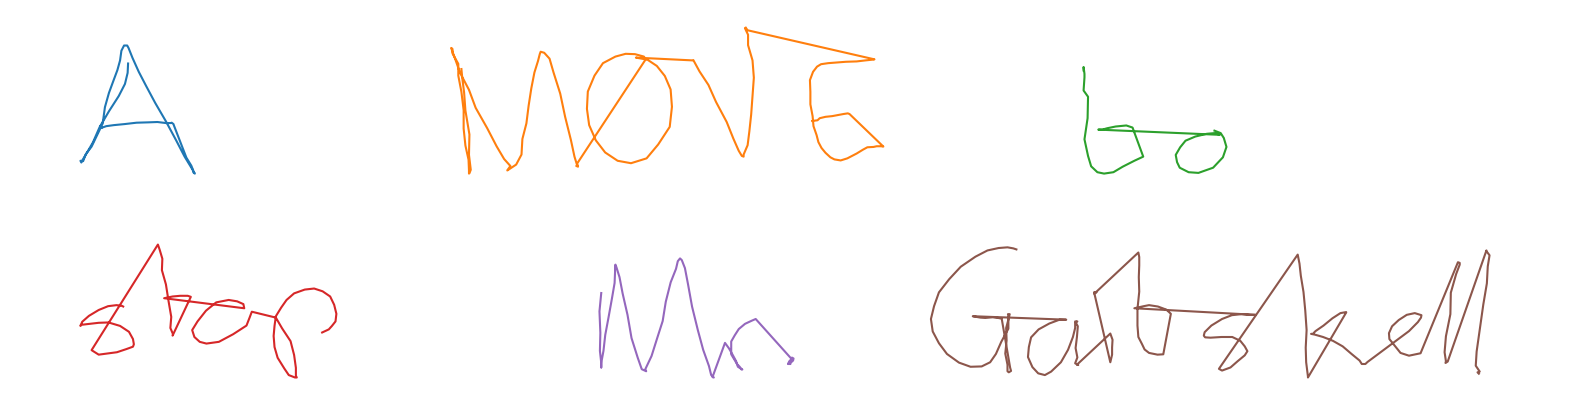

In [104]:
output_folder_path = '../../DataSet/IAM-Online/test_str_model/Images/'
width_list, image_list = create_list(output_folder_path)
stroke_path = '../../DataSet/IAM-Online/test_str_model/Strokes/'
stroke_array = []
for strokes in os.listdir(stroke_path):
    if strokes.endswith(".npy"):
        strokes = np.load(stroke_path + strokes)
        stroke_array.append(strokes)

lines = translate_strokes(stroke_array, page_width, width_list, space_bn_words=30)
